## Considera√ß√µes Iniciais

Treinar modelos que envolvam t√©cnicas de Deep Learning e detec√ß√£o de imagens geralmente necessitam de uma grande quantia de dados para realizar predi√ß√µes precisas e construir modelos robustos.

√â importante tamb√©m frisarmos que, para os requisitos propostos queremos realizar a tarefa de **Detec√ß√£o de Objetos**, que difere da tarefa de **Classifica√ß√£o de Imagens** uma vez que essa segunda n√£o se preocupa em encontrar o objeto na imagem (por meio de *bounding box* por exemplo), mas sim informar que imagem √© de determinada classe.

Um algoritmo bastante utilizado para tarefas de detec√ß√£o de objeto em imagens √© o algoritmo YOLO, este utiliza da l√≥gica de encadeamento de CNNs (Redes Neurais Convolucionais) para realizar tarefas de vis√£o computacional. Al√©m disso o YOLO √© um modelo j√° treinado em uma enorme base de imagens, fazendo com que ele generalize muito bem a tarefa de detec√ß√£o.

Com as informa√ß√µes ditas acima, para o objetivo desejado podemos utilizar o modelo YOLO e reaproveitar seus pesos, realizando um processo de Fine-tuning, ou seja iremos ajust√°-lo ao nosso dataset de imagens de fuma√ßa repassado. A utiliza√ß√£o do YOLO √© bem simples e amig√°vel com o pacote `ultralytics`, e a sua vers√£o mais nova √© a vers√£o 11, que ser√° utilizada para este projeto.



In [ ]:
# !pip install ultralytics
# !pip install opencv-python

In [13]:
!git clone https://github.com/renneruan/desafio-data-science-2025.git

Cloning into 'desafio-data-science-2025'...
remote: Enumerating objects: 3174, done.
remote: Total 3174 (delta 0), reused 0 (delta 0), pack-reused 3174 (from 2)
Receiving objects: 100% (3174/3174), 119.36 MiB | 37.08 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (4585/4585), done.


In [5]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from ultralytics import YOLO
from smoke_detection.utils.commons import get_latest_folder

## Coleta das Imagens



Com a utiliza√ß√£o do YOLO em mente, precisamos de um dataset que possua imagens e suas correspond√™ncias de fuma√ßa/fogo em bounding box, iniciei a busca de imagens que possam se aproximar das desejadas na biblioteca de imagens https://universe.roboflow.com/.

O objetivo na cole√ß√£o era encontrar um dataset de imagens possivelmente tiradas por c√¢meras em torres, como n√£o temos essa informa√ß√£o f√°cil, escolhemos um dataset que:
- A fuma√ßa/fogo n√£o estivesse t√£o pr√≥ximo da c√¢mera;
- Pudessemos tra√ßar uma linha do horizonte definida;
- Sem imagens de drone, sat√©lite ou demais vistas a√©reas.
- Neste primeiro momento evitei tamb√©m datasets com muitas imagens direcionadas para a chama.

Foi utilizada as palavras chaves: *wildfire smoke detection forest fire*.

Um dataset que atendeu as especifica√ß√µes foi o:
https://universe.roboflow.com/tristandeeplearnnig/wildfire-smoke-detection-v7bqc

√â poss√≠vel realizar o download do dataset utilizando o snippet de c√≥digo abaixo, por√©m para garantir a disponibiliza√ß√£o e evitar a necessidade de cadastro para recuperar a API key, ele tamb√©m foi baixado em zip e salvo no reposit√≥rio Git (apenas para car√°ter de projeto, dados de produ√ß√£o podem ser sens√≠veis e n√£o devem ser salvos em Git).

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="_")
# project = rf.workspace("tristandeeplearnnig").project("wildfire-smoke-detection-v7bqc")
# version = project.version(1)
# dataset = version.download("yolov11")


Observa√ß√µes: Por utilizar um dataset baixado de terceiro, a n√£o ser que verifiquemos imagem por imagem n√£o podemos garantir a qualidade da rotula√ß√£o e cria√ß√£o dos bounding boxes, al√©m de garantir a total falta de Data Leakege por exemplo. A biblioteca YOLO n√£o apresenta fun√ß√µes nativas para verificar em grande escala essa designa√ß√£o. Na pr√≥xima se√ß√£o irei verificar o perfil do bounding box de uma pequena amostra das imagens baixadas.

Temos como quantia:
- Treino: 1.378
- Valida√ß√£o: 147
- Teste: 74

O dataset apresenta apenas uma classe: Smoke

## Verificar o perfil das imagens

Irei realizar uma verifica√ß√£o manual do perfil da rotulagem e das imagens, para isso irei gerar as imagens com as informa√ß√µes de Bounding Box em uma pasta a parte, onde podemos visualizar se as Bounding Box criadas est√£o correspondente a fuma√ßa.

Para manter este notebook enxuto, criei as fun√ß√µes auxiliares para ler o arquivo YAML de caminho dos dados e criar as imagens com as bounding box nos arquivos `src/utils.py` e `src/image_evaluation.py` respectivamente.

In [ ]:
from src.smoke_detection.utils.commons import read_yaml
from src.smoke_detection.utils.image_evaluation import iterate_images_and_labels

all_datasets_path = "datasets/"
dataset_name = "smoke_data/"
dataset_path = os.path.join(all_datasets_path, dataset_name)
data_file_path = os.path.join(dataset_path, "data/data.yaml")

images_with_bb_path = os.path.join(dataset_path, "manual_evaluation", dataset_name)
path_file = read_yaml(data_file_path)

labels = iterate_images_and_labels(
    os.path.join(dataset_path, path_file["train"]),
    images_with_bb_path
)

Arquivo yaml: datasets/smoke_data/data/data.yaml carregado com sucesso.
Imagens para avalia√ß√£o visual criadas.


Com as imagens geradas na pasta `output/evaluation_images` foi poss√≠vel perceber algumas caracter√≠sticas do conjunto de dados utilizado:

- H√° a presen√ßa de muitas imagens repetidas, por exemplo 2 imagens id√™nticas ou quase id√™nticas para o mesmo foco de fuma√ßa; Podemos posteriormente elencar formas de identificar essas duplicidades e excluir dos nossos dados de treino.
- As imagens j√° est√£o no tamanho 640x640, tamanho esperado para aplica√ß√£o ao YOLO;
- Algumas imagens j√° apresentam uma c√≥pia em flip horizontal, esta poderia ser uma etapa do pr√©-processamento, uma vez que pegamos a imagem e invertemos horizontalmente para que o modelo possa assimilar caracter√≠sticas da fuma√ßa tanto crescente para o lado direito como para o esquerdo. Este comportamento levanta a d√∫vida se essa etapa de pr√©-processamento segue necess√°ria.

Al√©m disso os labels contidos nos arquivos de r√≥tulo YOLO foram salvos para serem retornados.

In [18]:
# Exemplo de array com objetos (dtype=object)
labels = np.array(labels, dtype=object)
none_elements = labels[labels == None]
none_elements

array([], dtype=object)

Vemos que todas as imagens apresentam uma Bounding Box, ou seja, n√£o h√° imagens que nos traga a informa√ß√£o apenas de background, em outras condi√ß√µes pode ser interessante adicionar imagens que n√£o possuam o objeto a ser detectado para um melhor treinamento do modelo.

A t√≠tulo de exemplifica√ß√£o vamos coletar aleatoriamente algumas imagens do conjunto de treino (com a Bounding Box desenhada).

In [19]:
image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["train"])) if f.endswith(('.jpg'))]
random_images = random.sample(image_files, 5)
random_images

['ck0txsj116ojr0848emet52dc_jpeg_jpg.rf.8fb9f00466b7ef183aed858acf2d31c4.jpg',
 'ck0tyq31o6ryb08488lus3geb_jpeg_jpg.rf.af60f276426d12172672bab6e8ca2aae.jpg',
 'ck0l9zam2nl6c0a46g4g3m6c4_jpeg_jpg.rf.5d6c66bc7270ab455e05f06bd11453c7.jpg',
 'ck0t3kjngndaa0701i76i8q2c_jpeg_jpg.rf.144501680e4259fcebdcdc0f3fd2b44f.jpg',
 'ck0qc8ib3k6v40721gt60o67m_jpeg_jpg.rf.3522b93f46648c029abfeded99137b28.jpg']

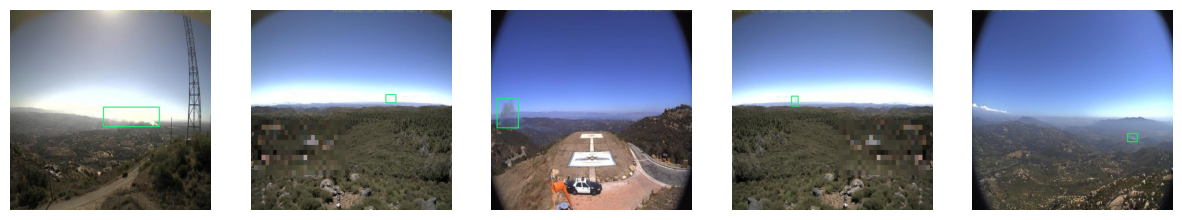

In [20]:
def print_images_in_row(path, images_list):
    plt.figure(figsize=(15, 12))
    for i, img_name in enumerate(images_list):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        # plt.title(img_name)

    plt.show()

print_images_in_row(images_with_bb_path, random_images)


Essa amostra j√° no mostra v√°rias diferen√ßas entre as imagens como em n√≠vel de brilho, escala de cores e satura√ß√£o, al√©m da poss√≠vel presen√ßa por exemplo de objetos.

## Pr√©-processamento


Para a etapa de pr√©-processamento, pesquisei como occo para detectar fuma√ßa sem a utiliza√ß√£o de modelos de IA, para verificar quais opera√ß√µes RGB poderiam ser realizadas.


- Normaliza√ß√£o/Adequar brilho -> jogar para 0 a 1 Escalonamento (sigmoid) para tan √© -1 e 1 
- Transformar pra escala cinza 
- Aplicar filtro em brilho coeficiente de odson
- rotate
- tensorflow. data augmentation
- conv net - conv mix, conv mix, resnet, mobile net, v66, cascade e racascade, tensorflow
- scikit-image
- Adicionar Ru√≠do -> Filtro
- Tentar verificar bordas ou outros processamentos de artigos

TODO: Pesquisar melhores etapas de pr√©-processamento para fuma√ßa

https://www.sciencedirect.com/science/article/abs/pii/S1290072902013972
https://www.mdpi.com/2073-8994/12/7/1075
https://www.mdpi.com/1999-4907/15/5/839

## Treinamento do Modelo

Nesta etapa iremos inserir nossas imagens de treino ao modelo YOLOv11 para realizar o Fine-tuning do mesmo a nossa tarefa de detec√ß√£o de fuma√ßa.

In [ ]:
model = YOLO("yolo11n.pt") # pt para modelo pr√©-treinado

# Treina o modelo no conjunto train da pasta data
# imgsz j√° tem como valor padr√£o 640
model.train(
    data=os.path.abspath(data_file_path),
    epochs=20,
    batch=100,
    device=0,
    seed=42
)

print("Treinamento finalizado.")

Ultralytics 8.3.78 üöÄ Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/smoke_data/data/data.yaml, epochs=20, time=None, patience=100, batch=100, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

train: Scanning /content/datasets/smoke_data/data/train/labels.cache... 1378 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1378/1378 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/smoke_data/data/valid/labels.cache... 147 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 147/147 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00078125), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ‚úÖ
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      14.5G       2.11      4.668      1.797        109        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:25<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:07<00:00,  7.39s/it]

                   all        147        147    0.00315      0.946     0.0907     0.0323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      13.3G       1.74      3.055      1.363        114        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:19<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.86s/it]

                   all        147        147    0.00302      0.905      0.399      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      13.3G      1.625      2.472      1.316        111        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:20<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.92s/it]

                   all        147        147      0.584     0.0748      0.114     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      13.3G      1.599      2.164      1.319        107        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:21<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.84s/it]

                   all        147        147      0.183     0.0733     0.0811     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      13.3G      1.609      2.022      1.349         98        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:23<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.98s/it]

                   all        147        147      0.693      0.231      0.343       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      13.3G      1.586      1.775      1.317        118        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:22<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.03s/it]

                   all        147        147     0.0896      0.109     0.0438     0.0146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      13.3G      1.569      1.612      1.309        105        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:22<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.10s/it]

                   all        147        147     0.0993     0.0544     0.0193    0.00779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      13.3G      1.564      1.521      1.329        114        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:22<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.98s/it]

                   all        147        147     0.0474     0.0884     0.0208    0.00624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      13.3G      1.549      1.415      1.316        120        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:21<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.99s/it]

                   all        147        147      0.451      0.593      0.536      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      13.3G      1.516      1.296      1.298        120        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:23<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.79s/it]

                   all        147        147      0.759      0.639      0.738      0.356


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      13.3G       1.46      1.273      1.295         78        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:26<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.78s/it]

                   all        147        147       0.43      0.524      0.451      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      13.3G      1.451      1.147      1.255         78        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:20<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.24s/it]

                   all        147        147      0.472      0.388      0.426      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      13.3G      1.413      1.091      1.249         76        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:20<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.50s/it]

                   all        147        147      0.841      0.758      0.838      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      13.3G      1.396      1.007      1.238         78        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:19<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.70s/it]

                   all        147        147      0.745      0.816      0.838      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      13.3G      1.367       0.98      1.218         78        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:25<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.81s/it]

                   all        147        147      0.819      0.891      0.899       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      13.3G      1.321     0.9257      1.189         78        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:20<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:02<00:00,  2.00s/it]

                   all        147        147      0.886      0.846      0.919      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      13.3G      1.277     0.8878      1.176         78        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:22<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.90s/it]

                   all        147        147      0.859      0.871      0.917      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      13.3G      1.263     0.8441       1.16         78        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:23<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.93s/it]

                   all        147        147      0.874      0.849       0.91      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      13.3G      1.223     0.8049      1.145         77        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:22<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.90s/it]

                   all        147        147       0.87      0.867      0.919      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      13.3G      1.188     0.7674      1.123         78        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:21<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.65s/it]

                   all        147        147      0.895       0.85      0.921      0.547



20 epochs completed in 0.156 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.78 üöÄ Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.23s/it]


                   all        147        147      0.896       0.85      0.921      0.547
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cdba0368290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Vamos salvar o resultado do melhor modelo `best.pt` na pasta `artifacts/model`. Deve ser rodado antes do eval, uma vez que este ir√° criar uma nova pasta com os resultados de avalia√ß√£o.

In [ ]:
latest_folder = get_latest_folder(Path("runs/detect_without_preprocessing"))

best_model = os.path.join(latest_folder, "weights/best.pt")

print(best_model)
destination = "artifacts/model/best.pt"
if os.path.exists(best_model):
    shutil.move(best_model, destination)
    print("Arquivo de melhor modelo movido com sucesso.")
else:
    print("O arquivo n√£o foi encontrado.")

runs\detect_without_preprocessing\train32\weights/best.pt
O arquivo existe!


## Avalia√ß√£o do modelo

A chamada para o m√©todo `model.val()` retorna a avalia√ß√£o do modelo nas imagens presentes na pasta `valid` do dataset, ou seja, nosso conjunto de teste, com isso podemos acessar as imagens com gr√°ficos de m√©trica para an√°lise posterior.

In [25]:
# Avalia no conjunto de valida√ß√£o (valid)
metrics = model.val()

Ultralytics 8.3.78 üöÄ Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/datasets/smoke_data/data/valid/labels.cache... 147 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 147/147 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:05<00:00,  2.91s/it]


                   all        147        147      0.885       0.85       0.92      0.546
Speed: 0.2ms preprocess, 12.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train32



O modelo YOLO possui como resultado as seguintes m√©tricas para a dete√ß√£o de "objetos" em imagens:

In [26]:
metrics.results_dict

{'metrics/precision(B)': 0.8852380942238742,
 'metrics/recall(B)': 0.8503401360544217,
 'metrics/mAP50(B)': 0.9198825408563613,
 'metrics/mAP50-95(B)': 0.5459896200440815,
 'fitness': 0.5833789121253095}

A partir da [documenta√ß√£o de m√©tricas](https://docs.ultralytics.com/guides/yolo-performance-metrics/#choosing-the-right-metrics) referente ao YOLO, temos a seguinte explica√ß√£o para as m√©tricas de classe mostradas anteriormente:

- Precision: A acur√°cia de quantas detec√ß√µes foram corretas.
- Recall A habilidade do modelo em detectar todas as inst√¢ncias do objeto em imagens, nesse caso fuma√ßa.
- mAP50: Mede a precis√£o m√©dia das detec√ß√µes do modelo considerando um limiar de IoU (Intersection over Union, ou seja o bounding box predito com o verdadeiro) de 50%.
- mAP50-95: Semelhante a m√©trica anterior por√©m fornecendo um limiar vari√°vel, avaliando o modelo em detec√ß√µes mais dif√≠ceis, importante para casos em que a precis√£o √© essencial.
- A m√©trica fitness √© uma m√©trica composta para medir o desempenho do modelo de forma geral.

A seguir temos as m√©tricas de velocidade:

In [27]:
metrics.speed

{'preprocess': 0.24059831292440637,
 'inference': 12.37989200680371,
 'loss': 0.0002114965985927075,
 'postprocess': 1.4660636122435684}

Temos como m√©trica de tempo principal o valor de ms necess√°rio para a a√ß√£o de infer√™ncia de uma √∫nica imagem.

Podemos visualizar tamb√©m os gr√°ficos de m√©trica gerados pelo m√©todo val.


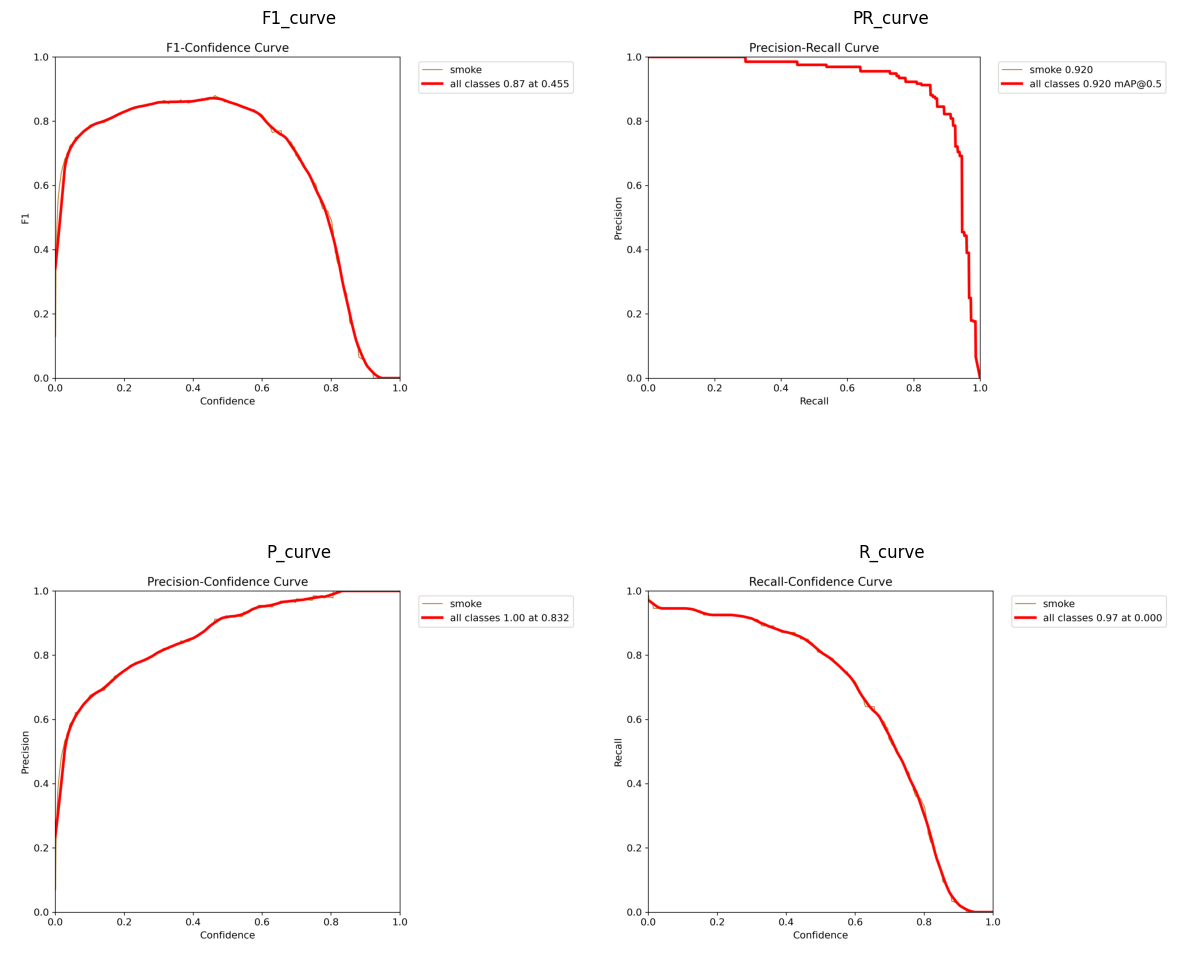

In [ ]:
latest_folder = get_latest_folder(Path("../runs/detect_without_preprocessing"))

graphs = [
    "F1_curve",
    "PR_curve",
    "P_curve",
    "R_curve"
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, graph_name in enumerate(graphs):
    img_path = Path(os.path.join(latest_folder, f"{graph_name}.png")) 
    if img_path.exists():
        img = cv2.imread(img_path)
        
        ax = axes[i // 2, i % 2]
        ax.imshow(img)
        ax.set_title(graph_name)
        ax.axis("off") 

plt.tight_layout()
plt.show()


Temos:
- A curva F1, em que o F1-Score se trata da m√©dia harm√≥nica da precis√£o e da revoca√ß√£o (recall), para a curva temos este valor para diferentes limiares de confian√ßa, visualizamos que na medida que a confian√ßa aumenta a m√©trica de F1 tende a abaixar. Em um limiar m√©dio de 0.5 temos um F1 Score acima de 0.8.
- A curva de Precision e Recall, no geral essa curva √© importante para lidar com problema de desbalanceamento quando h√° a exist√™ncia de m√∫ltiplas classes, podemos a partir dela analisa o trade off entre as duas m√©tricas.
- Curva de Precis√£o e Confian√ßa, semelhante a primeira curva por√©m apenas para precis√£o.
- Curva de Recall e Confian√ßa, semelhante a primeira curva por√©m apenas para revoca√ß√£o.

Podemos verificar tamb√©m as matrizes de confus√£o geradas, como s√≥ temos apenas uma classe, a matriz de confus√£o possui apenas os valores de fuma√ßa e background (classe gerada automaticamente).   

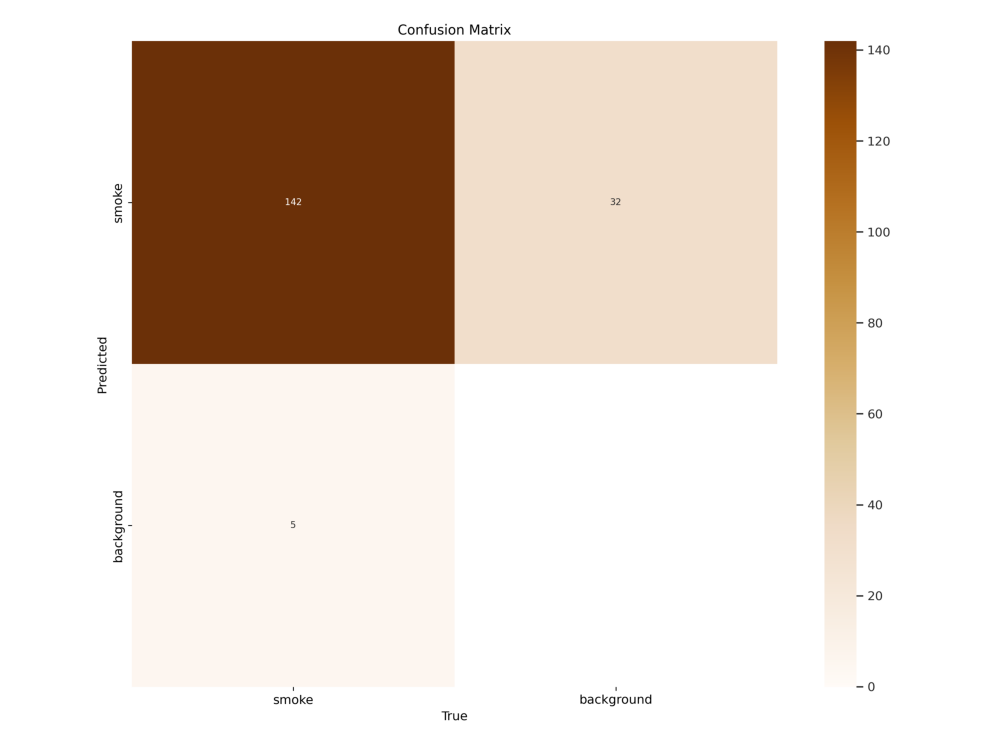

In [ ]:
plt.figure(figsize=(10, 10))
img_path = Path(os.path.join(latest_folder, "confusion_matrix.png")) 
if img_path.exists():
    img = cv2.imread(img_path)
    
    plt.imshow(img)
    plt.axis("off") 

plt.tight_layout()
plt.show()


Temos a predomin√¢ncia de falsos positivos do que falsos negativos, considerando o o caso de fogo em floresta queremos reduzir ao m√°ximo os casos de falsos negativos, uma vez que deixar a incid√™ncia do fogo se alastrar √© o pior cen√°rio, enquanto o falso positivo pode ser verificado e validade por um agente humano antes de ser tomada qualquer a√ß√£o.

## Predi√ß√£o em imagens de teste

In [26]:
test_image_files = [f for f in os.listdir(os.path.join(dataset_path, path_file["test"])) if f.endswith(('.jpg'))]
random_test_images = random.sample(test_image_files, 5)
random_test_images

NameError: name 'dataset_path' is not defined

In [ ]:
results = {}
for image in random_test_images:
    test_image = os.path.join(
        dataset_path,
        path_file["test"],
        image
    )

    results[image] =  model(test_image)

results


image 1/1 /content/datasets/smoke_data/data/test/images/ck0nftcfgka7e0848a9ie2b3b_jpeg_jpg.rf.792243de554062c1def618b87c5bad5d.jpg: 640x640 1 smoke, 10.5ms
Speed: 3.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'smoke'}
 obb: None
 orig_img: array([[[ 26,  73,  77],
         [ 64, 111, 115],
         [ 69, 116, 120],
         ...,
         [ 41,  56,  58],
         [ 41,  56,  58],
         [ 41,  56,  58]],
 
        [[ 29,  74,  78],
         [ 58, 105, 109],
         [ 34,  79,  83],
         ...,
         [ 42,  57,  59],
         [ 41,  56,  58],
         [ 41,  56,  58]],
 
        [[ 36,  78,  83],
         [ 47,  92,  96],
         [ 14,  56,  61],
         ...,
         [ 42,  57,  59],
         [ 42,  57,  59],
         [ 41,  56,  58]],
 
        ...,
 
        [[ 10,  21,  19],
         [  3,  14,  12],
         [  9,  20,  18],
         ...,
         [ 80,  93,  91],
         [ 80,  93,  91],
         [ 77,  90,  88]],
 
        [[ 22,  35,  33],
         [ 24,  37,  35],
         [ 35,  48,  46],
         ...,
         [ 78,  91,

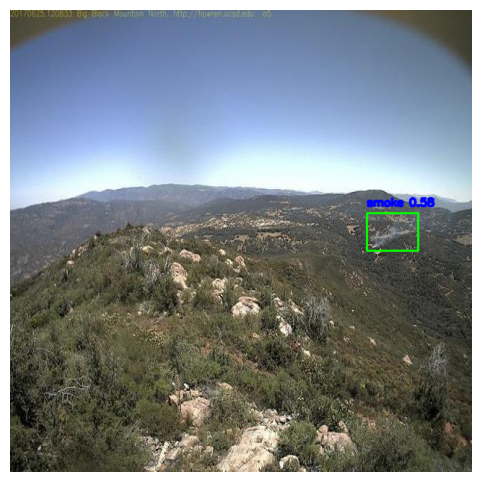

In [ ]:
for test_image in test_images:

img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Score de confian√ßa
        conf = float(box.conf[0])

        # Classe de fuma√ßa (smoke)
        cls = int(box.cls[0])
        label = f"{model.names[cls]} {conf:.2f}"

        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        img = cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                          0.5, (255, 0, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.show()


In [50]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !zip -r /content/runs.zip /content/

# from google.colab import files
# files.download('/content/runs.zip')